# Cells Instance Segmentation: Starter Notebook Using Mask-RCNN

## 📘 Notebook Overview

1. **Setup & Config**  
   - Fixes random seeds for reproducibility  
   - Defines paths, image dimensions, device, and hyperparameters  

2. **Augmentations & RLE Utils**  
   - Augmentations pipelines for training and test using Albumentations  
   - RLE decode/encode functions and overlap removal  

3. **Datasets & DataLoaders**  
   - `CellDataset` for training/validation (with masks + boxes)  
   - `CellTestDataset` for inference  
   - PyTorch DataLoaders with custom collate functions  

4. **Model**  
   - Mask R-CNN with ResNet-50 FPN backbone  
   - Custom heads for 2 classes (background + cell)
     

5. **Training & Validation**  
   - training loop with mask & total loss logging  
   - Validation run per epoch and checkpoint saving  
   - Selects best model based on val loss  

6. **Inference & Submission**  
   - Runs test predictions  
   - Filters and binarizes masks, removes overlaps  
   - Encodes masks as RLE and generates `submission.csv`

# Imports

In [4]:
import os
import time
import random
import warnings
import collections

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as F
from torchvision.ops.boxes import masks_to_boxes

from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from tqdm import tqdm
import timm  # For ConvNeXt backbone
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
# Fix randomness
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

fix_all_seeds(2025)

## Configuration

In [6]:
TRAIN_CSV = "/kaggle/input/kaust-vs-kku-tournament-round-3/cells_segmentation/train.csv"
TRAIN_PATH = "/kaggle/input/kaust-vs-kku-tournament-round-3/cells_segmentation/train"
TEST_PATH = "/kaggle/input/kaust-vs-kku-tournament-round-3/cells_segmentation/test"

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Data Hyperparameters
WIDTH = 704     # Same as original datasets images size ---> Important in segmentation tasks
HEIGHT = 520
PCT_IMAGES_VALIDATION = 0.1 

#### Modeling Hyperparameters
BATCH_SIZE = 1
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0005
BOX_DETECTIONS_PER_IMG = 100  # maximum number of detections per image

#### Inference Hyperparameters
BOXES_CONF = 0.0   # 0 = keeps all boxes
MASK_THRESHOLD = 0.5   # Threshold for binarizing the masks


# Augmentations

In [7]:
def get_transform(train=True, height=HEIGHT, width=WIDTH):
    if train:
        return A.Compose(
            [
                A.Resize(height, width),
                
                # Flips and Rotation
                A.OneOf([
                    A.HorizontalFlip(p=1),
                    A.VerticalFlip(p=1),
                    A.RandomRotate90(p=1),
                ], p=0.4),

                # Spatial transforms
                A.ShiftScaleRotate(
                    shift_limit=0.02, scale_limit=0.1, rotate_limit=10, 
                    border_mode=0, p=0.4
                ),

                # Noise and blur
                A.OneOf([
                    A.GaussNoise(var_limit=(0.001, 0.01), p=0.5),
                    A.MedianBlur(blur_limit=3, p=0.5),
                ], p=0.2),

                # Color transforms
                A.OneOf([
                    A.RandomBrightnessContrast(
                        brightness_limit=0.1, contrast_limit=0.1, p=1.0
                    ),
                    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=1.0),
                ], p=0.3),

                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)),
                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
        )
    else:
        return A.Compose(
            [
                A.Resize(height, width),
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)),
                ToTensorV2(),
            ]
        )

## Training Dataset and DataLoader

In [8]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [9]:
import os
import numpy as np
import collections
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision.transforms import ToTensor

class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.height = HEIGHT
        self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                'image_id': row['id'],
                'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                'annotations': row["annotation"]
            }

    def get_box(self, a_mask):
        pos = np.where(a_mask)
        if pos[0].size == 0 or pos[1].size == 0: 
            return [0, 0, 1, 1]
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        info = self.image_info[idx]
        img = Image.open(info['image_path']).convert("RGB")
        img_np = np.array(img)

        # Decode masks & boxes
        masks = []
        boxes = []
        for rle in info['annotations']:
            mask = rle_decode(rle, (self.height, self.width)).astype('uint8')
            if mask.sum() == 0:
                continue
            masks.append(mask)
            boxes.append(self.get_box(mask))

        labels = [1] * len(masks)

        # Remove invalid boxes
        valid = [i for i, box in enumerate(boxes) if box[2] > box[0] and box[3] > box[1]]
        boxes = [boxes[i] for i in valid]
        masks = [masks[i] for i in valid]
        labels = [labels[i] for i in valid]

        
        if self.transforms and len(boxes) > 0:
            augmented = self.transforms(
                image=img_np,
                masks=masks,
                bboxes=boxes,
                labels=labels
            )
            img = augmented['image'].float()
            masks = [torch.as_tensor(m, dtype=torch.uint8) for m in augmented['masks']]
            boxes = torch.as_tensor(augmented['bboxes'], dtype=torch.float32)
            labels = torch.as_tensor(augmented['labels'], dtype=torch.int64)
        else:
            img = ToTensor()(img_np).float()
            masks = [torch.as_tensor(m, dtype=torch.uint8) for m in masks]
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        # Handle empty masks case
        if len(masks) == 0:
            masks = torch.zeros((0, self.height, self.width), dtype=torch.uint8)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            masks = torch.stack(masks)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        return img, target

    def __len__(self):
        return len(self.image_info)

# Split Data
#### (group on "id" to ensure different images between train and val)

In [10]:
from sklearn.model_selection import train_test_split

df_base = pd.read_csv(TRAIN_CSV)

# Step 1: Split unique image IDs
unique_ids = df_base['id'].unique()
train_ids, val_ids = train_test_split(
    unique_ids,
    test_size=PCT_IMAGES_VALIDATION,
    random_state=42,
    shuffle=True
)

# Step 2: Slice annotations
df_train = df_base[df_base['id'].isin(train_ids)].copy().reset_index(drop=True)
df_val   = df_base[df_base['id'].isin(val_ids)].copy().reset_index(drop=True)

# Placeholder for later pseudo-labeled data
df_pseudo = pd.DataFrame(columns=['id', 'annotation'])

# Step 3: Sanity check
print(f"Images in train set:           {len(train_ids):,}")
print(f"Annotations in train set:     {len(df_train):,}")
print(f"Images in validation set:     {len(val_ids):,}")
print(f"Annotations in val set:       {len(df_val):,}")

Images in train set:           381
Annotations in train set:     48,918
Images in validation set:     43
Annotations in val set:       4,147


In [11]:
from torch.utils.data import DataLoader

ds_train = CellDataset(
    image_dir=TRAIN_PATH,
    df=df_train,
    transforms=get_transform(train=True)
)

dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

ds_val = CellDataset(
    image_dir=TRAIN_PATH,
    df=df_val,
    transforms=get_transform(train=False)
)

dl_val = DataLoader(
    ds_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

Image 0 range after un-normalization: min=0.0431, max=0.9255


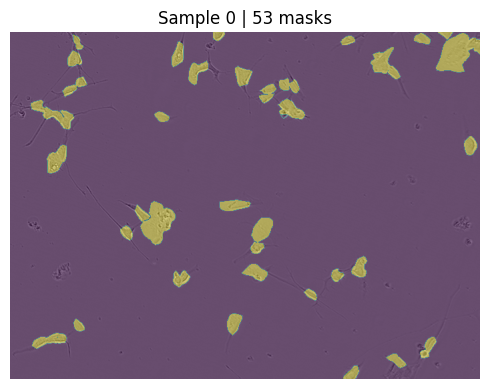

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch

def show_augmented_batch(
    dataloader, 
    num_images=4, 
    mask_alpha=0.4, 
    mean=(0.5, 0.5, 0.5), 
    std=(0.25, 0.25, 0.25)
):
    """
    Show one batch of images and their combined masks.
    Assumes normalization with given mean/std.
    """
    try:
        images, targets = next(iter(dataloader))
    except StopIteration:
        print("❌ DataLoader is empty.")
        return

    batch_size = len(images)
    n_show = min(num_images, batch_size)
    
    cols = min(2, n_show)
    rows = math.ceil(n_show / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.atleast_1d(axes).flatten()

    for i in range(n_show):
        # Un-normalize image
        img_t = images[i].cpu().clone()
        for c in range(img_t.shape[0]):
            img_t[c] = img_t[c] * std[c] + mean[c]
        img_np = img_t.permute(1, 2, 0).numpy()
        print(f"Image {i} range after un-normalization: min={img_np.min():.4f}, max={img_np.max():.4f}")
        img_np = np.clip(img_np, 0, 1)

        # Combine all instance masks
        combined_mask = np.zeros(img_np.shape[:2], dtype=bool)
        for m in targets[i]['masks']:
            m_np = m.cpu().numpy()
            if m_np.ndim == 3:
                m_np = m_np.squeeze(0)
            combined_mask = np.logical_or(combined_mask, m_np.astype(bool))

        ax = axes[i]
        ax.imshow(img_np)
        if combined_mask.any():
            ax.imshow(combined_mask, alpha=mask_alpha)
        ax.set_title(f"Sample {i} | {len(targets[i]['masks'])} masks")
        ax.axis('off')

    # Hide unused axes
    for j in range(n_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_augmented_batch(dl_train, num_images=BATCH_SIZE)

# Training

## Model

In [13]:
# ==== Imports ====
import torch
import torch.nn as nn
from timm import create_model

# من torchvision
from torchvision.ops import FeaturePyramidNetwork
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.models.detection import MaskRCNN

# ==== Backbone + FPN ====
class TimmBackboneWithFPN(nn.Module):
    def __init__(
        self,
        name: str = "convnext_tiny.fb_in1k",
        out_channels: int = 256,
        pretrained: bool = True,
    ):
        super().__init__()

        self.body = create_model(name, features_only=True, pretrained=pretrained)

        in_channels_list = self.body.feature_info.channels()

        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels,
            extra_blocks=LastLevelMaxPool(),
        )

        self.out_channels = out_channels

    def forward(self, x):
        feats = self.body(x)
        feats = {str(i): f for i, f in enumerate(feats)}
        return self.fpn(feats)

# ==== Model builder ====
def get_model(num_classes: int = 2, detections_per_img: int = 100):
    backbone = TimmBackboneWithFPN(
        name="convnext_tiny.fb_in1k",
        out_channels=256,
        pretrained=True,
    )

    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        box_detections_per_img=detections_per_img,
    )
    return model

# ==== Usage example ====

model = get_model()
model.to(DEVICE)
model.train()

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): TimmBackboneWithFPN(
    (body): FeatureListNet(
      (stem_0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout

## Training loop

In [ ]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import gc
import time
import torch

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

# ==== Optimizer & Scheduler ====
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)
scaler = GradScaler()

n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_losses = []
best_val_loss = float("inf")

# ==== Training Loop ====
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n Starting epoch {epoch} of {NUM_EPOCHS}")
    time_start = time.time()

    # ===== Training =====
    model.train()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    pbar = tqdm(dl_train, desc=f"[Epoch {epoch}] Training", leave=False)

    for images, targets in pbar:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        with autocast():
            loss_dict = model(images, targets)

            if any(torch.isnan(v).any() or torch.isinf(v).any() for v in loss_dict.values()):
                print("Skipping batch due to NaN or Inf in loss.")
                continue

            loss = sum(loss for loss in loss_dict.values())

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        pbar.set_postfix({"Loss": f"{loss.item():.3f}", "Mask": f"{loss_mask:.3f}"})

        del images, targets, loss_dict, loss
        torch.cuda.empty_cache()
        gc.collect()

    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches

    # ===== Validation =====
    val_loss_accum = 0.0
    val_loss_mask_accum = 0.0
    pbar_val = tqdm(dl_val, desc=f"[Epoch {epoch}] Validation", leave=False)

    model.train()  
    with torch.no_grad():
        for images, targets in pbar_val:
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            with autocast():
                val_loss_dict = model(images, targets)

                if any(torch.isnan(v).any() or torch.isinf(v).any() for v in val_loss_dict.values()):
                    print(" Skipping val batch due to NaN or Inf in loss.")
                    continue

                val_batch_loss = sum(loss for loss in val_loss_dict.values())

            val_loss_accum += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            pbar_val.set_postfix({"Val Loss": f"{val_batch_loss.item():.3f}"})

            del images, targets, val_loss_dict, val_batch_loss
            torch.cuda.empty_cache()
            gc.collect()

    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    elapsed = time.time() - time_start

    validation_losses.append(val_loss)
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_model.bin")
        print(f"✅ Best model saved! Val loss: {val_loss:.4f}")

    # Logging
    prefix = f"[Epoch {epoch:2d}/{NUM_EPOCHS}]"
    print(f"{prefix} Train Loss: {train_loss:.3f} | Mask: {train_loss_mask:.3f}")
    print(f"{prefix} Val   Loss: {val_loss:.3f} | Mask: {val_loss_mask:.3f}")
    print(f"{prefix} Time Elapsed: {elapsed:.0f} sec")

    torch.cuda.empty_cache()
    gc.collect()


 Starting epoch 1 of 20


[Epoch 1] Training:   2%|▏         | 8/381 [00:14<05:50,  1.06it/s, Loss=47.780, Mask=21.179]

# Inference

## Test Dataset and DataLoader

In [136]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [fname[:-4] for fname in os.listdir(self.image_dir) 
                          if fname.endswith('.png')]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        img = Image.open(image_path).convert("RGB")
        img_np = np.array(img)  # H x W x 3

        if self.transforms:
            augmented = self.transforms(image=img_np)
            img_tensor = augmented['image']
        else:
            img_tensor = ToTensor()(img_np)

        return {'image': img_tensor, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)


# instantiate the dataset and dataloader
ds_test = CellTestDataset(
    TEST_PATH,
    transforms=get_transform(train=False)
)

test_loader = DataLoader(
    ds_test,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=lambda x: x
)

In [137]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

## Load the model with lowest val_loss

In [138]:
# Epochs with their losses
print(dict((enumerate([round(v, 4) for v in validation_losses]))))
best_epoch = np.argmin(validation_losses)
print(f"Epoch with lowest val_loss: {best_epoch}")

{0: 2.679, 1: 1.947, 2: 1.7203, 3: 1.7602, 4: 1.5968, 5: 1.7479, 6: 1.6478, 7: 1.7302, 8: 1.538, 9: 1.5041}
Epoch with lowest val_loss: 9


## Run predictions

In [139]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BOXES_CONF = 0.5
MASK_THRESHOLD = 0.5

model.load_state_dict(torch.load("/kaggle/working/best_model.bin"))
model.eval()
model.to(DEVICE)

def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

class CellTestDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [fname[:-4] for fname in os.listdir(self.image_dir) if fname.endswith('.png')]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        img = Image.open(image_path).convert("RGB")
        img_np = np.array(img)

        if self.transforms:
            augmented = self.transforms(image=img_np)
            img_tensor = augmented['image']
        else:
            img_tensor = ToTensor()(img_np)

        return {'image': img_tensor, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)

test_ds = CellTestDataset(TEST_PATH, transforms=None)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, collate_fn=lambda x: x)

submission = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference"):
        sample = batch[0]           # since batch_size=1
        img = sample['image'].to(DEVICE)
        image_id = sample['image_id']
        
        outputs = model([img])[0]

        any_mask = False
        prev_masks = []

        for mask, score in zip(outputs['masks'], outputs['scores']):
            if score.item() < BOXES_CONF:
                continue
            any_mask = True
            bin_mask = mask.squeeze().cpu().numpy() > MASK_THRESHOLD
            bin_mask = remove_overlapping_pixels(bin_mask, prev_masks)
            prev_masks.append(bin_mask)
            rle = rle_encoding(bin_mask)
            submission.append((image_id, rle))

        if not any_mask:
            submission.append((image_id, "-1"))

df_sub = pd.DataFrame(submission, columns=['id','annotation'])
df_sub["idx"] = range(len(df_sub))
df_sub = df_sub[["idx","id","annotation"]].replace({"":"-1"})
df_sub.to_csv("submission.csv", index=False)
print("✅ submission.csv created!")
print(df_sub.head())


Inference: 100%|██████████| 182/182 [02:52<00:00,  1.06it/s]

✅ submission.csv created!
   idx            id                                         annotation
0    0  8bd09ff70b13  24319 5 25021 8 25724 10 26426 12 27130 12 278...
1    1  8bd09ff70b13  70072 3 70776 6 71479 8 72182 10 72886 11 7359...
2    2  8bd09ff70b13  101567 6 102271 7 102974 10 103677 12 104381 1...
3    3  8bd09ff70b13  258036 5 258736 1 258738 9 259438 14 260141 17...
4    4  8bd09ff70b13  322631 7 323335 7 324037 9 324741 10 325444 11...


# Show some samples from test

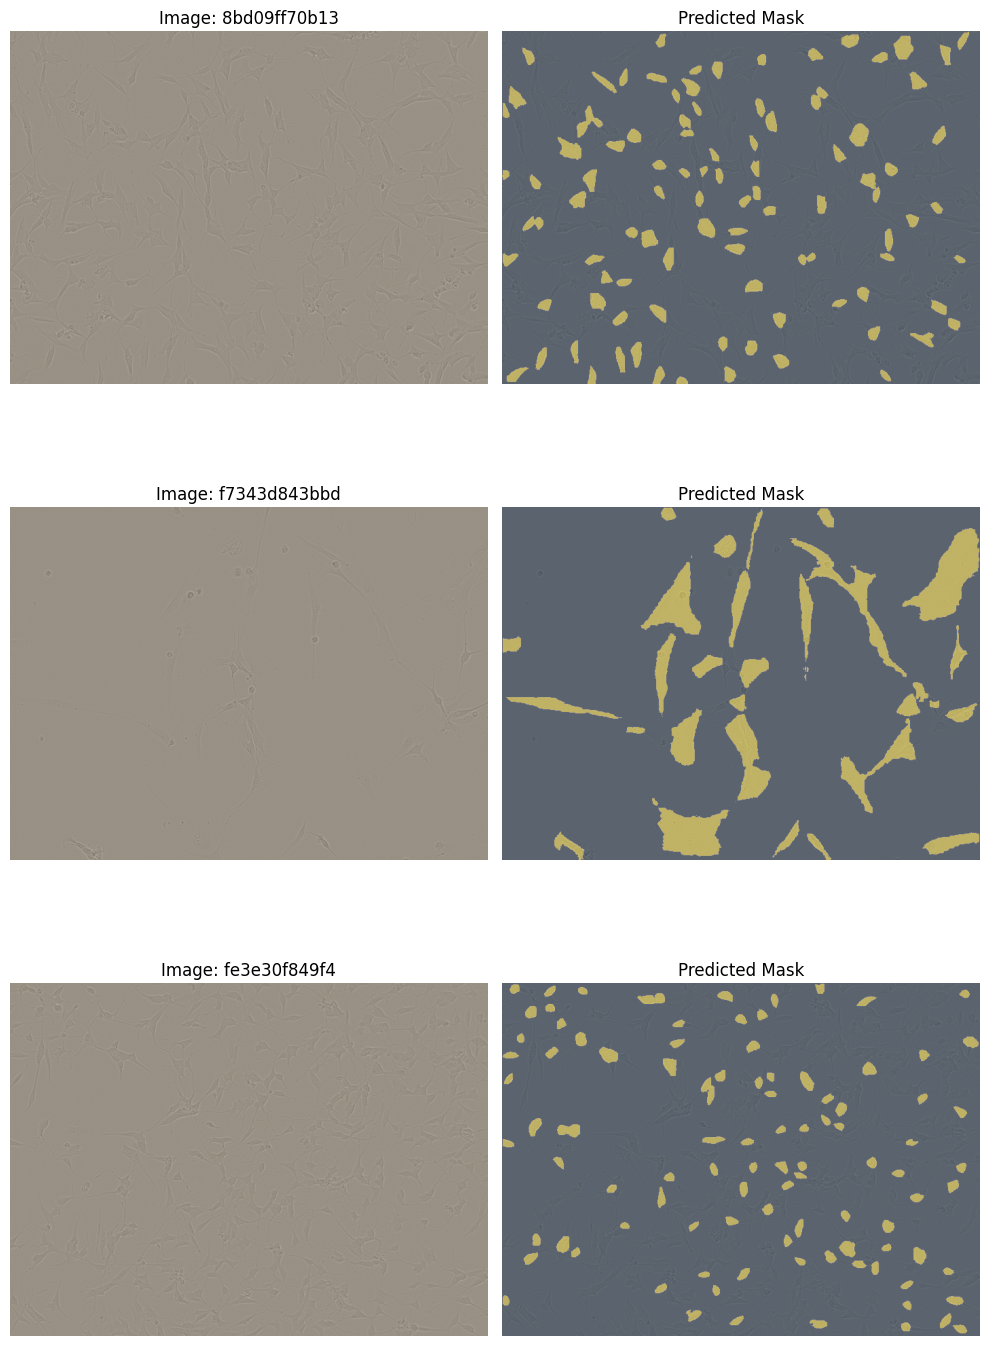

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch
import math

def show_test_predictions(model, loader, device, num_samples=3,
                          mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225),
                          mask_alpha=0.4, box_conf=BOXES_CONF, mask_thr=MASK_THRESHOLD):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, 
                             figsize=(10, 5 * num_samples))
    axes = axes.reshape(num_samples, 2)
    
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            if idx >= num_samples:
                break
            sample = batch[0]
            img_t = sample['image'].to(device)      # C×H×W tensor
            image_id = sample['image_id']
            
            # 2) Forward pass
            outputs = model([img_t])[0]
            
            # 3) Un-normalize for display
            img_disp = img_t.cpu().clone()
            for c in range(3):
                img_disp[c] = img_disp[c] * std[c] + mean[c]
            img_np = img_disp.permute(1,2,0).numpy()
            img_np = np.clip(img_np, 0, 1)
            
            # 4) Build combined predicted mask
            combined_mask = np.zeros(img_np.shape[:2], dtype=bool)
            prev = []
            for mask, score in zip(outputs['masks'], outputs['scores']):
                if score.item() < box_conf:
                    continue
                m = mask.cpu().numpy()[0] > mask_thr
                # remove overlaps if needed
                m = remove_overlapping_pixels(m, prev)
                prev.append(m)
                combined_mask = np.logical_or(combined_mask, m)
            
            # 5) Plot original
            ax_img = axes[idx, 0]
            ax_img.imshow(img_np)
            ax_img.set_title(f"Image: {image_id}")
            ax_img.axis('off')
            
            # 6) Plot prediction
            ax_pred = axes[idx, 1]
            ax_pred.imshow(img_np)
            ax_pred.imshow(combined_mask, alpha=mask_alpha, cmap='cividis')
            ax_pred.set_title("Predicted Mask")
            ax_pred.axis('off')
    
    plt.tight_layout()
    plt.show()

show_test_predictions(model, test_loader, DEVICE, num_samples=3)
